In [1]:
import rules as r
import utils
import time
import importlib
importlib.reload(r)
importlib.reload(utils)


(iris_train_x, iris_train_y), (iris_test_x, iris_test_y), iris_num_attrs, iris_num_classes, iris_lb, iris_ub = r.train_test_split("iris.csv")
(wine_train_x, wine_train_y), (wine_test_x, wine_test_y), wine_num_attrs, wine_num_classes, wine_lb, wine_ub = r.train_test_split("winequality-white.csv")


## Naive classifier
I start with naive classifier, that always selects the most frequent category in its training dataset. From that I get lower accuracy bound, under which no sane model should ever get.

In [55]:
print(f"Naive Iris error rate: {100 * (1-r.naive(iris_train_y, iris_test_y)):.3f}")
print(f"Naive Wine error rate: {100 * (1-r.naive(wine_train_y, wine_test_y)):.3f}")

Naive Iris error rate: 74.000
Naive Wine error rate: 54.623


## XGBoost benchmark for comparison
As a baseline benchmark, or maybe a target to which I would like to get close with my rule-based classifier, I took XGBoost's boosted trees with default settings and tried it on the datasets.

### Iris dataset

In [56]:
print(f"XGBoost Iris error rate: {100 * (1 - r.xgboost(iris_train_x, iris_train_y, iris_test_x, iris_test_y)):.3f}")

[11:37:31] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost Iris error rate: 8.000


### Wine quality dataset

In [57]:
print(f"XGBoost Wine-quality error rate: {100 * (1 - r.xgboost(wine_train_x, wine_train_y, wine_test_x, wine_test_y)):.3f}")

[11:37:40] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost Wine-quality error rate: 35.579


## GA baseline


In [7]:
import importlib
importlib.reload(r)
importlib.reload(utils)

r.run_experiment(exp_id="default-wine", input_file="winequality-white.csv", repeats=10, pop_size=100, max_gen=50, cx_prob=0.8, max_rules=10, mut_cls_prob=0.2, mut_cls_prob_change=0.1, mut_cond_prob=0.2, mut_cond_sigma=0.3, batch_size=10000, print_frequency=1)
r.run_experiment(exp_id="default-iris", input_file="iris.csv", repeats=10, pop_size=100, max_gen=50, cx_prob=0.8, max_rules=10, mut_cls_prob=0.2, mut_cls_prob_change=0.1, mut_cond_prob=0.2, mut_cond_sigma=0.3, batch_size=10000, print_frequency=1)



   10000     0.96     0.68     0.38
  110000     0.62     0.44     0.34
  210000     0.64     0.41     0.34
  310000     0.64     0.40     0.34
  410000     0.64     0.40     0.34
   10000     1.00     0.67     0.16
  110000     0.62     0.39     0.12
  210000     0.64     0.42     0.04
  310000     0.64     0.43     0.04
  410000     0.64     0.41     0.04
   10000     1.00     0.67     0.00
  110000     0.62     0.40     0.00
  210000     0.64     0.41     0.00
  310000     0.64     0.40     0.00
  410000     0.64     0.41     0.00
   10000     1.00     0.70     0.36
  110000     0.84     0.41     0.20
  210000     0.80     0.41     0.12
  310000     0.80     0.35     0.08
  410000     0.82     0.26     0.08
   10000     1.00     0.70     0.36
  110000     0.64     0.40     0.38
  210000     0.64     0.43     0.38
  310000     0.64     0.40     0.38
  410000     0.64     0.41     0.38
   10000     1.00     0.69     0.34
  110000     0.92     0.42     0.18
  210000     0.64     0.41  

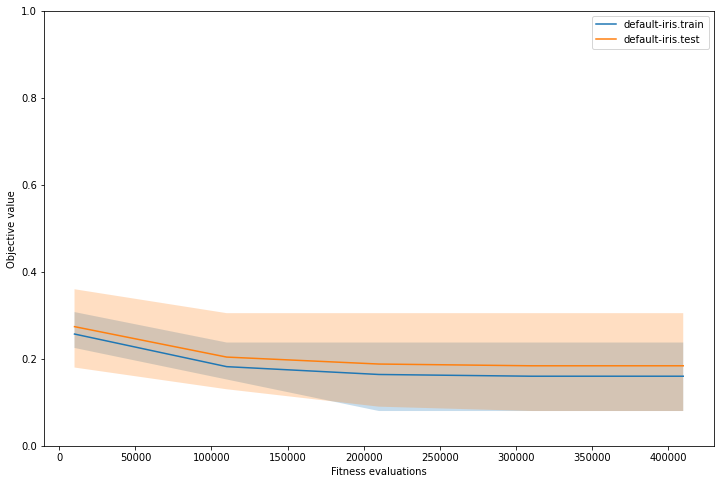

In [12]:
importlib.reload(r)
importlib.reload(utils)

r.plot_experiments("default-iris", stat_type=["fitness", "objective"])


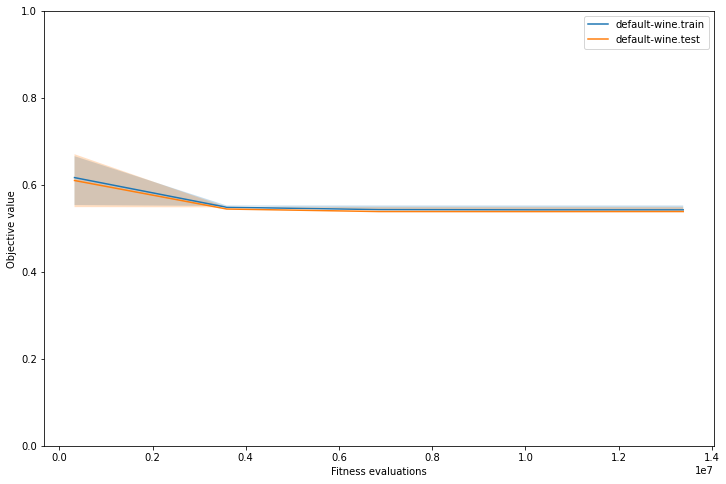

In [13]:
r.plot_experiments("default-wine", stat_type=["fitness", "objective"])

In both cases we see that the model isn't able to fit the training data, so we need model with more capacity. More rules per individual would probably help.

## Noisy fitness
Fitness evaluation during training takes too long if done on the whole training dataset. True, it is precise, but seems a bit wasteful.
Inspired by the training of neural networks, where the gradient isn't computed on the whole training dataset, but is instead approximated by the gradient of a small random batch, I approximate the fitness of an individual at each generation only by evaluating its performance on a random subset of training data of specified size (batch size).

This breaks elitism, where the strongest individual always survives, but we can compensate for the noise in the fitness by k-elitism, where k strongest individuals always survive. 

full eval on train + test data
done
    1000     1.00     0.98     0.74
full eval on train + test data
done
   11000     1.00     0.61     0.56
full eval on train + test data
done
   21000     0.69     0.56     0.56
full eval on train + test data
done
   31000     1.00     0.56     0.56
full eval on train + test data
done
   41000     0.56     0.56     0.56
full eval on train + test data
done
    1000     1.00     0.98     0.69
full eval on train + test data
done
   11000     1.00     0.69     0.69
full eval on train + test data
done
   21000     0.93     0.66     0.56
full eval on train + test data
done
   31000     1.00     0.57     0.56
full eval on train + test data
done
   41000     1.00     0.57     0.56
full eval on train + test data
done
    1000     1.00     0.99     0.82
full eval on train + test data
done
   11000     1.00     0.86     0.69
full eval on train + test data
done
   21000     1.00     0.73     0.69
full eval on train + test data
done
   31000     1.00     0.64  

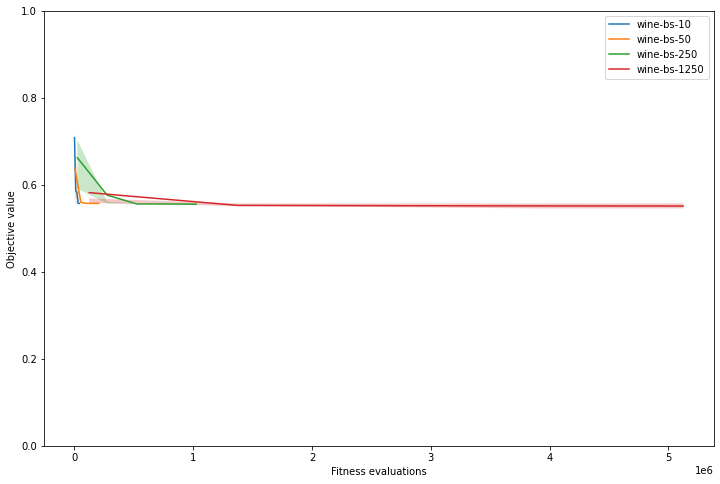

In [3]:
importlib.reload(r)

experiments = []
for batch_size in [10, 50, 250, 1250]:
    start = time.time()
    exp_name = f"wine-bs-{batch_size}"
    r.run_experiment(exp_id=exp_name, input_file="winequality-white.csv", repeats=10, pop_size=100, max_gen=50, cx_prob=0.8, max_rules=10, mut_cls_prob=0.2, mut_cls_prob_change=0.1, mut_cond_prob=0.2, mut_cond_sigma=0.3, batch_size=batch_size, eval_size=1000, print_frequency=1)
    experiments.append(exp_name)

    print(f"batch_size {batch_size} took {time.time() - start}")

r.plot_experiments(*experiments)


The performance doesn't detiorate even for small batches of size 10, so a lot of computation can be saved on fitness evaluation.

## Increased model capacity
Let's increase the number of rules per individual and see when the classifier is strong enough to fit the training data.


In [44]:
exp_names = []
for n_rules in [10, 20, 40, 80, 150, 300, 600]:
    name = f"iris-max-rules-{n_rules}"
    r.run_experiment(exp_id=name, input_file="iris.csv", repeats=10, pop_size=100, max_gen=100, max_rules=n_rules, print_frequency=1)
    exp_names.append(name)

 7: objective = 0.040000000000000036
Run 8: objective = 0.07999999999999996
Run 9: objective = 0.19999999999999996
   10000     1.00     0.68     0.38
  110000     0.62     0.37     0.10
  210000     0.64     0.39     0.10
  310000     0.92     0.43     0.10
  410000     0.64     0.41     0.10
  510000     0.64     0.43     0.10
  610000     0.96     0.44     0.10
  710000     0.64     0.42     0.10
  810000     0.64     0.43     0.10
  910000     0.64     0.41     0.10
   10000     1.00     0.67     0.24
  110000     0.62     0.39     0.18
  210000     0.62     0.41     0.18
  310000     0.64     0.44     0.08
  410000     0.64     0.40     0.08
  510000     0.74     0.40     0.08
  610000     0.64     0.41     0.08
  710000     0.64     0.42     0.08
  810000     0.64     0.40     0.08
  910000     0.64     0.44     0.08
   10000     0.92     0.69     0.28
  110000     0.62     0.41     0.10
  210000     0.62     0.40     0.10
  310000     0.64     0.41     0.10
  410000     0.64    

In [6]:
import rules as r
import utils
import importlib
importlib.reload(r)
importlib.reload(utils)
import functools
exp_names = []
for n_rules in [10, 20, 40, 80, 150, 300, 600]:
    name = f"iris-max-rules-{n_rules}"
    exp_names.append(name)


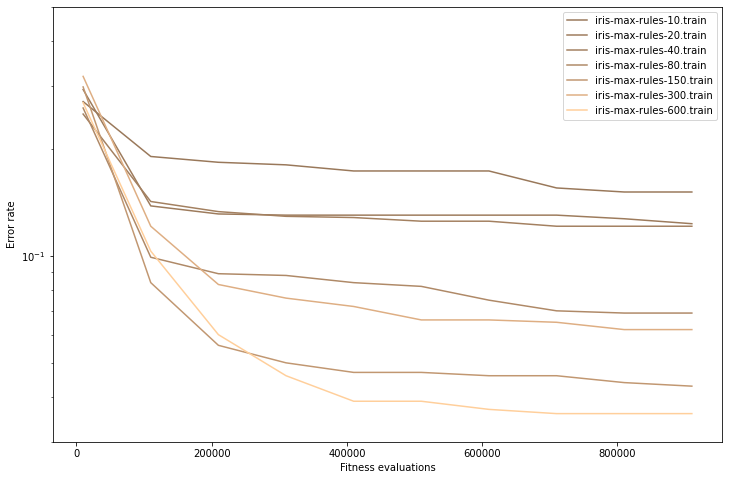

In [18]:
r.plot_experiments(*exp_names, stat_type=["fitness"], color=functools.partial(r.train_test_hue, low=-200, high=600), fill=False, log=True, ylim=(0.03, 0.5))

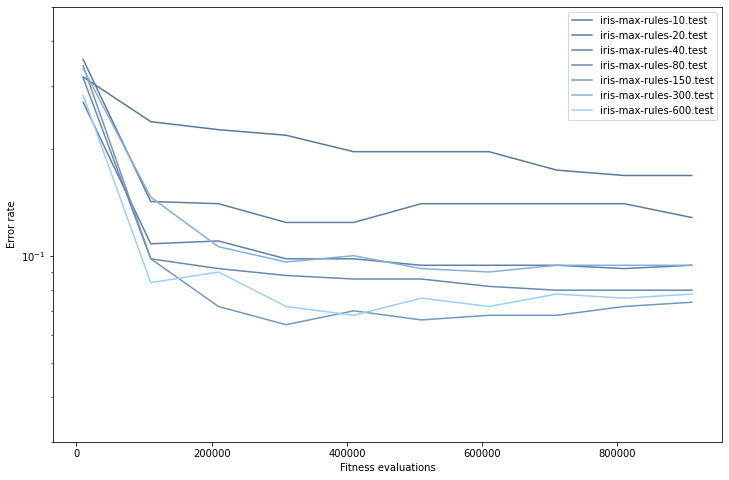

In [19]:
r.plot_experiments(*exp_names, stat_type=["objective"], color=functools.partial(r.train_test_hue, low=-200, high=600), fill=False, log=True, ylim=(0.03, 0.5))

At `max_rules=150` the model becomes strong enough to fit the training data and the test validation error is the lowest, after that it starts to overfit. It achieves ~8% validation error, which is the same as XGBoost. With such a small dataset of only 150 datapoints there probably isn't much more information to be learned and more sofisticated models would probably just overfit the data. Therefore I consider the Iris task solved.

Before I tackle the Winequality, I will first improve the classifier.